In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import itertools
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax

import jax.numpy as jnp
import netket as nk


/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: Debug multi-node HPC? `djaxrun -np 2 python Examples/Sharding/multi_process.py`

In [2]:
from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.netket_compat import get_sector_constraints
from src.acband import acband_form_factors, K_func1

In [3]:
sqrt3 = 3.0 ** 0.5
N_s = 28
N_f = 17

lB = 1.0
a_M = (((4 * np.pi) / sqrt3) ** 0.5) * lB
# resolution = 254
resolution = 1022
V1 = 1.0
v1 = 3 * V1 * (a_M ** 4) / (4 * np.pi) 
K = 0.8

2.6935473741771965 2.6935473741771965
2.693547374177197 2.693547374177197
2.6935473741771965 2.693547374177197 1

In [4]:
bz = {}

e1 = np.array([1, 0])
e2 = np.array([0, 1])
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)
t3 = (1 / 9) * (b2 - b3)
sample_lattice_27 = Lattice2D(np.stack([t1, t2]))
bz_27 = BrillouinZone2D(lattice, sample_lattice_27)
bz[27] = bz_27

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_28 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_28 = BrillouinZone2D(lattice, sample_lattice_28)
bz[28] = bz_28

# N = 25 grid
p1 = b1 + 2 * t3 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_25 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_25 = BrillouinZone2D(lattice, sample_lattice_25)
bz[25] = bz_25

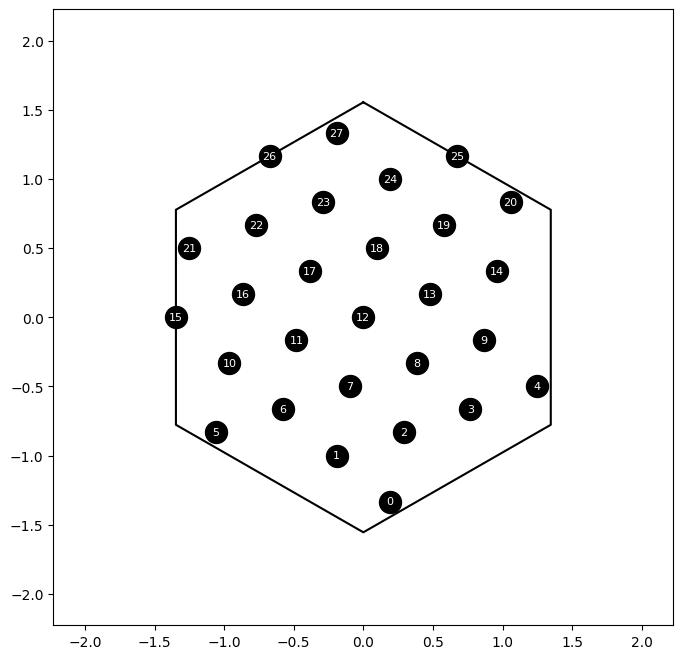

In [5]:
bz_N_s = bz[N_s]
sampled_momentums = bz_N_s.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6 / a_M, 6 / a_M)
ax.set_ylim(-6 / a_M, 6 / a_M)
plt.show()

In [6]:
constraints = get_sector_constraints(bz_N_s, N_f)
hilbs = [
    nk.hilbert.SpinOrbitalFermions(
        n_orbitals=N_s, n_fermions=N_f, constraint=constraint
    ) for constraint in constraints
]

In [ ]:
for k_index, sector in enumerate(hilbs):
    print(f"Sector {k_index}:")
    print(f"  Total Momentum: {bz_N_s[k_index]}")
    print(f"  Dimension: {sector.n_states}")

Sector 0:
  Total Momentum: [ 0.19239624 -1.33296026]


In [ ]:
A = N_s * lattice.unit_cell_area

def V(q):
    return -v1 * np.linalg.norm(q) ** 2
    
K_func = partial(K_func1, args=(K, b1, b2, b3))

start = time.time()
G_coords, ac_ff = acband_form_factors(
    bz[N_s],
    lB,
    K_func,
    resolution
)
G_idx_map = {tuple(G.tolist()): i for i, G in enumerate(G_coords)}
end = time.time()

print(f"N_s = {N_s} AC band form factors computed in {end - start:.2f} seconds")
print(f"{ac_ff.shape=}")

In [ ]:
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.experimental.operator import ParticleNumberConservingFermioperator2nd


hamiltonians = []
for sector_index, sector in enumerate(hilbs):
    print(f"Constructing Hamiltonian for sector {sector_index}...")
    H = 0.0
    
    for k1, k2, p in itertools.product(range(N_s), repeat=3):
        k1_coords = bz_N_s.k_coords[k1]
        k2_coords = bz_N_s.k_coords[k2]
        p_coords = bz_N_s.k_coords[p]
        
        k1_f_coords = k1_coords + p_coords
        k2_f_coords = k2_coords - p_coords
        
        k1_f_folded, g1 = bz_N_s.fold_coord(k1_f_coords)
        k2_f_folded, g2 = bz_N_s.fold_coord(k2_f_coords)
        
        k1_f = bz_N_s.idx_from_coord[k1_f_folded]
        k2_f = bz_N_s.idx_from_coord[k2_f_folded]

        g1_idx = G_idx_map[tuple(g1.tolist())]
        g2_idx = G_idx_map[tuple(g2.tolist())]
        
        Lambda1 = ac_ff[g1_idx, k1_f, k1]
        Lambda2 = ac_ff[g2_idx, k2_f, k2]
        
        p_vec = bz_N_s.k_points[p]
        V_p = V(p_vec)
        c_dag_k1_f = cdag(sector, k1_f)
        c_dag_k2_f = cdag(sector, k2_f)
        c_k2 = c(sector, k2)
        c_k1 = c(sector, k1)
        H += complex((1 / (2 * A)) * V_p * Lambda1 * Lambda2) * (c_dag_k1_f @ c_dag_k2_f @ c_k2 @ c_k1)
    H = ParticleNumberConservingFermioperator2nd.from_fermionoperator2nd(H)
    hamiltonians.append(H)

In [ ]:
spectrums = []
com_momentums = []

for k_index, (sector, H) in enumerate(zip(hilbs, hamiltonians)):
    print(f"Diagonalizing sector {k_index} with dimension {sector.n_states}...")
    start = time.time()
    evals = nk.exact.lanczos_ed(H, k=10)
    end = time.time()
    print(f"  Diagonalized in {end - start:.2f} seconds")
    spectrums.append(evals)
    com_momentums.append(bz_N_s.k_points[k_index])

In [ ]:
k_coms_flatten = []
energies_flatten = []

for com_momentum, spectrum in zip(com_momentums, spectrums):
    k_coms_flatten.extend([np.linalg.norm(com_momentum)] * len(spectrum))
    energies_flatten.extend(spectrum.tolist())
    
k_coms_flatten = np.array(k_coms_flatten)
energies_flatten = np.array(energies_flatten)
energies_flatten -= np.min(energies_flatten)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(k_coms_flatten, energies_flatten, color='red')
plt.xlabel(r'$|\mathbf{k}_{\mathrm{COM}}|$')
plt.ylabel('Energy')
plt.title(f'ED Spectrum (N={N_s})')
plt.savefig('ed_spectrum.png')
plt.show()